In [2]:
import cdh23.loadData
import cdh23.analyzeData

mice = ['m1321']
data = cdh23.loadData.loadTheData(mice)

------------------
Mouse: m1321
------------------
Loading data...
Date: 221205
Calculating dF...
Neurons x Time: (1518, 14000)
Loading stim history...


In [117]:
import matplotlib.pyplot as plt
import numpy as np

ordered = data.processAndSort('m1321')
sessions = len(ordered[0])
for i in range(sessions):
                print("Aalyzing session:", i + 1)
                neu, stims = ordered[0][i], ordered[1][i]
                trial_type   = stims[0][:, 0] #only 0 for first session, #stimHistories[mou] is 200x3, len 200
                trials = neu #len 200
                trial_size  = trials[0].shape[1] #was trials[0]
                Nneurons = trials[0].shape[0]



Aalyzing session: 1


----------------
ANALYZING MOUSE: m1321
----------------
Aalyzing session: 1
1518 neurons.
569 selective neurons.
463 onset. 106 offset.
Tone: 4 kHz
113 onset. 13 offset.
Tone: 8 kHz
135 onset. 14 offset.
Tone: 16 kHz
89 onset. 31 offset.
Tone: 32 kHz
77 onset. 30 offset.
Tone: 64 kHz
49 onset. 18 offset.


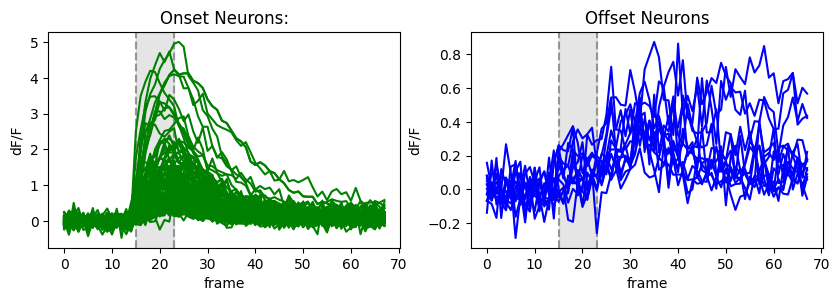

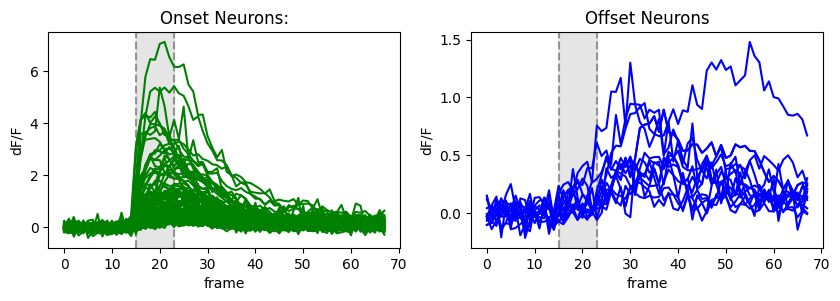

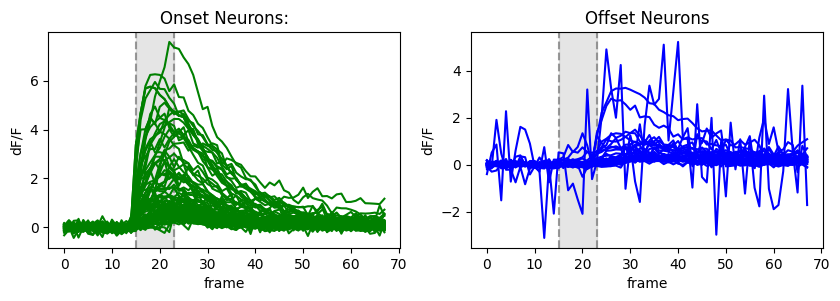

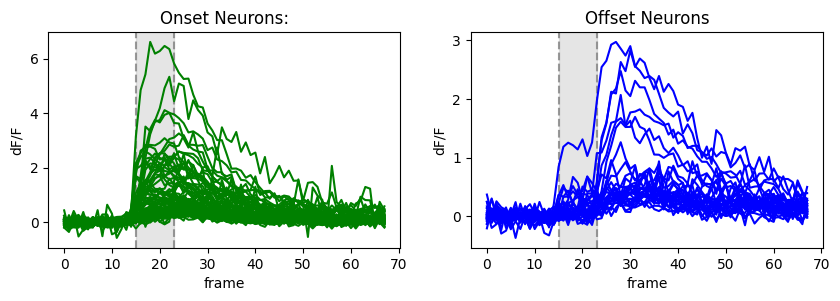

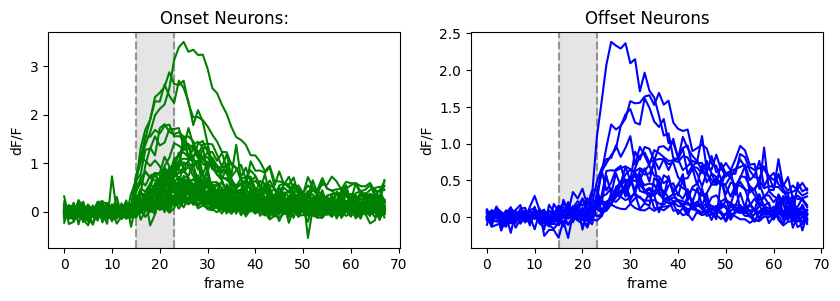

In [216]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from matplotlib.lines import Line2D

shade_alpha = 0.2
lines_alpha = 0.8
frames_pre_stim = 14 
frames_post_stim = 45
start_stim = 15
end_stim = 23
trial_types  = ["4 kHz", "8 kHz", "16 kHz", "32 kHz", "64 kHz"]
attenuations = ["0 dB", "20 dB", "40 dB", "60"]
t_type_ind = [range(40),range(40,80), range(80, 120), range(120, 160), range(160,200)]
t_type_ind2 = [range(40),range(40,80), range(80, 120), range(120, 160), range(160,200), range(200,220)]
a_type_ind = [range(10),range(10,20), range(20, 30), range(30, 40)]
#pal = sns.color_palette('husl', 9)
#print(pal)
pal = [(44/256, 123/256, 182/256), (171/256, 217/256, 233/256), (255/256, 255/256, 191/256), (253/256, 174/256, 97/256), (215/256, 25/256, 28/256)]
        #%config InlineBackend.figure_format = 'svg'

def z_score(X):
# X: ndarray, shape (n_features, n_samples)
        ss = StandardScaler(with_mean=True, with_std=True)
        Xz = ss.fit_transform(X.T).T
        return Xz
    
def add_stim_to_plot(ax):
        ax.axvspan(start_stim, end_stim, alpha=shade_alpha,
               color='gray')
        ax.axvline(start_stim, alpha=lines_alpha, color='gray', ls='--')
        ax.axvline(end_stim, alpha=lines_alpha, color='gray', ls='--')
    
def add_orientation_legend(ax):
        custom_lines = [Line2D([0], [0], color=pal[k], lw=4) for
                    k in range(len(trial_types))]
        labels = ['{}$^\circ$'.format(t) for t in trial_types]
        ax.legend(custom_lines, labels,
              frameon=False, loc='center left', bbox_to_anchor=(1, 0.5))
        plt.tight_layout(rect=[0,0,0.9,1])


for mouse in mice :
        print("----------------")
        print("ANALYZING MOUSE:", mouse)
        print("----------------")
        ordered = data.processAndSort(mouse)
        sessions = len(ordered[0])
        for i in range(sessions):
                print("Aalyzing session:", i + 1)
                neu, stims = ordered[0][i], ordered[1][i]
                trial_type   = stims[0][:, 0] #only 0 for first session, #stimHistories[mou] is 200x3, len 200
                trials = neu #len 200
                trial_size  = trials[0].shape[1] #was trials[0]
                Nneurons = trials[0].shape[0]

                meanToneTraces = np.zeros([Nneurons, 5, trials[0].shape[1]])

                selective = 0
                onset = 0
                offset = 0

                print(Nneurons, "neurons.")
                for neuron in range(Nneurons):
                        for t, ind in enumerate(t_type_ind):
                                ind = list(ind)
                                x = np.zeros((trials[0].shape[1]))
                                k = 0
                                for indeces in ind :
                                        x = np.add(x, trials[indeces][neuron, :])
                                        k = k + 1
                                x = x/k
                                meanToneTraces[neuron, t, :] = x
                
                selectiveNeurons = []
                for neuron in range(Nneurons):
                        maxResponse = np.argmax(np.mean(meanToneTraces[neuron, :, 20:40], axis=1))
                        tempOthers = np.zeros([4, trials[0].shape[1]])

                        for i in range(5) :
                                if i != maxResponse and i == 4:
                                        tempOthers[i - 1, :] = meanToneTraces[neuron, i, :]
                                elif i != maxResponse : 
                                        tempOthers[i, :] = meanToneTraces[neuron, i, :]

                        if np.mean(meanToneTraces[neuron, maxResponse, 20:40]) > 2*np.std(tempOthers[:, :]) :
                                selective = selective + 1
                                selectiveNeurons.append([neuron, meanToneTraces[neuron, maxResponse, :], maxResponse] )

                print(selective, "selective neurons.")

                types = np.zeros([selective, 1]) #num selective neurons by onset/offset characterization
                for i in range(selective) :
                        toPlot = selectiveNeurons[i]
                        if np.max(toPlot[1]) > 8.5 :
                                toPlot = selectiveNeurons[i - 1] #did this to cut out noisy neurons, lost one good onset
                        #if np.argmax(toPlot[1]) <= 26 : #this threshold was set based on peak shape
                        if np.mean(toPlot[1][20:30]) > np.mean(toPlot[1][30:40]):
                                onset = onset + 1
                                types[i] = 1 #one is onset
                                #if toPlot[2] == toneOfInterest :
                                        #plt.plot(np.linspace(0, 67, 68),toPlot[1], 'g') #comment out to see one or other
                        #if np.argmax(toPlot[1]) > 26 :
                        else :
                                offset = offset + 1
                                types[i] = 0 #0 is offset
                                #if toPlot[2] == toneOfInterest :
                                        #plt.plot(np.linspace(0, 67, 68),toPlot[1], 'b')
                        #plt.plot(np.linspace(0, 67, 68),meanToneTraces[toPlot[0], :, :].T, 'r')
                        #plt.plot(np.linspace(0, 67, 68),toPlot[1], 'g')
                
                print(onset, "onset.", offset, "offset.")

               
                
                for t, ind in enumerate(t_type_ind):
                        f, axes = plt.subplots(1, 2, figsize=[10, 2.8], sharey=False,
                       sharex=True)
                        for ax in axes:
                                add_stim_to_plot(ax)
                        print("Tone:", trial_types[t])
                        numOn = 0
                        numOff = 0
                        for i in range(selective) :
                                toPlot = selectiveNeurons[i]
                                if np.max(toPlot[1]) > 8 :
                                        toPlot = selectiveNeurons[i - 1] #again, this needs to be modified
                                tone = toPlot[2]
                                type = types[i]
                                if t == tone :
                                        if type == 1 :
                                                plt.subplot(1, 2, 1)
                                                plt.plot(np.linspace(0, 67, 68),toPlot[1], 'g')
                                                numOn += 1
                                        else :
                                                plt.subplot(1, 2, 2)
                                                plt.plot(np.linspace(0, 67, 68),toPlot[1], 'b')
                                                numOff += 1
                        print(numOn, "onset.", numOff, "offset.")
                        plt.subplot(1, 2, 1)
                        plt.title("Onset Neurons:")
                        plt.xlabel("frame")
                        plt.ylabel("dF/F")
                        plt.subplot(1, 2, 2)
                        plt.title("Offset Neurons")
                        plt.xlabel("frame")
                        plt.ylabel("dF/F")

TSNE vs PCA

TSNE NO BL (BETTER)

(1518, 200)


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

PCs: (0, 1)
t_type: 4 kHz
t_type: 8 kHz
t_type: 16 kHz
t_type: 32 kHz
t_type: 64 kHz


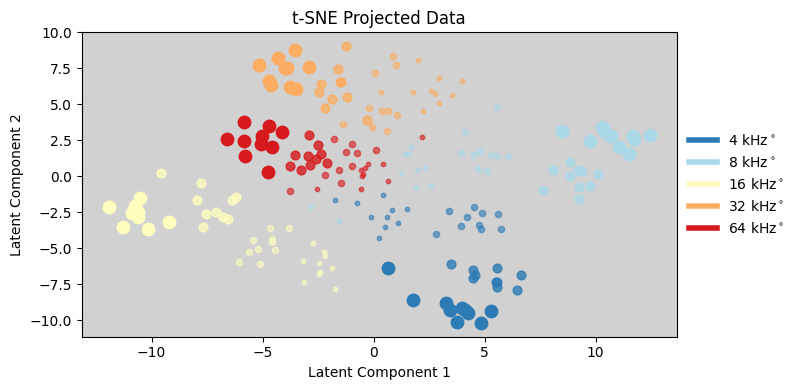

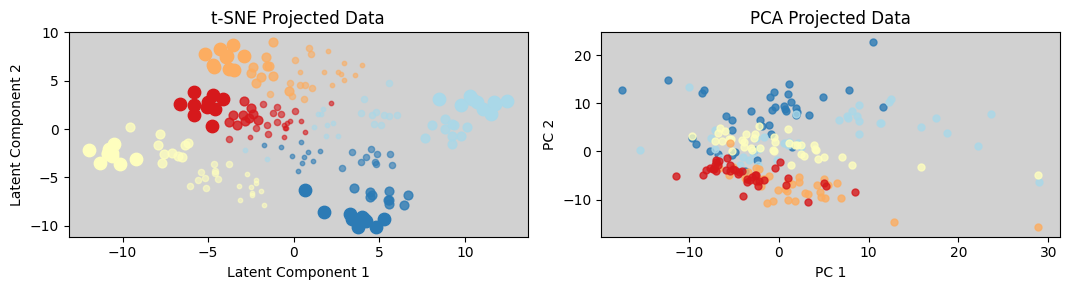

In [230]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

#Xr = np.vstack([t[:, frames_pre_stim:frames_pre_stim+20].max(axis=1) for t in trials]).T
Xr = np.vstack([t[:, frames_pre_stim:frames_post_stim].mean(axis=1) for t in trials]).T
print(Xr.shape)

Xr_sc = z_score(Xr)

X_embedded = TSNE(n_components=2, perplexity=25, early_exaggeration=3, learning_rate=15, init="random").fit_transform(Xr_sc.T)


fig = plt.figure(figsize=[9, 4])
ax = plt.gca()
ax.set_facecolor((210/256, 210/256, 210/256))
for t, ind in enumerate(t_type_ind):
    for a, indexes in enumerate(ind):
        if a < 10 :
            plt.scatter(X_embedded[indexes, 0], X_embedded[indexes, 1], c=pal[t], s=80, alpha=1.0)
        elif a < 20 :
            plt.scatter(X_embedded[indexes, 0], X_embedded[indexes, 1], c=pal[t], s=40, alpha=0.8)
        elif a < 30 :
            plt.scatter(X_embedded[indexes, 0], X_embedded[indexes, 1], c=pal[t], s=20, alpha=0.6)
        else :
            plt.scatter(X_embedded[indexes, 0], X_embedded[indexes, 1], c=pal[t], s=10, alpha=0.6)

plt.title("t-SNE Projected Data")
plt.xlabel("Latent Component 1")
plt.ylabel("Latent Component 2")
add_orientation_legend(fig.get_axes()[0])

#X3_embedded = TSNE(n_components=3, perplexity=20, early_exaggeration=4, learning_rate=24, init="random").fit_transform(Xr_sc.T)
#fig = plt.figure(figsize=[9, 6])
#ax = fig.add_subplot(111, projection='3d')
#for t, ind in enumerate(t_type_ind):
    #ax.scatter(X3_embedded[ind, 0], X3_embedded[ind, 1], X3_embedded[ind, 2], c=pal[t], s=25, alpha=0.8)
#add_orientation_legend(ax)

#Xr = np.vstack([t[:, frames_pre_stim:frames_pre_stim+20].max(axis=1) for t in trials]).T
        #Xr = np.vstack([t[:, frames_pre_stim:-frames_post_stim].max(axis=1) for t in trials]).T
        # or the baseline-corrected mean
        #Xr = np.vstack([t[:, frames_pre_stim:-frames_post_stim].mean(axis=1) - t[:, 0:frames_pre_stim].mean(axis=1) for t in trials]).T

#Xr_sc = z_score(Xr)

plt.figure(figsize=[12, 3])
plt.subplot(1, 2, 1)
ax = plt.gca()
ax.set_facecolor((210/256, 210/256, 210/256))
for t, ind in enumerate(t_type_ind):
    for a, indexes in enumerate(ind):
        if a < 10 : 
            plt.scatter(X_embedded[indexes, 0], X_embedded[indexes, 1], c=pal[t], s=80, alpha=1.0)
        elif a < 20 :
            plt.scatter(X_embedded[indexes, 0], X_embedded[indexes, 1], c=pal[t], s=40, alpha=0.8)
        elif a < 30 :
            plt.scatter(X_embedded[indexes, 0], X_embedded[indexes, 1], c=pal[t], s=20, alpha=0.6)
        else :
            plt.scatter(X_embedded[indexes, 0], X_embedded[indexes, 1], c=pal[t], s=10, alpha=0.6)

plt.title("t-SNE Projected Data")
plt.xlabel("Latent Component 1")
plt.ylabel("Latent Component 2")
add_orientation_legend(fig.get_axes()[0])
pca = PCA(n_components=15)
Xp = pca.fit_transform(Xr_sc.T).T
projections = [(0, 1)] #projections = [(2, 0), (2, 1), (2, 3), (2, 4), (2,5)]
counter = 0
xhats = np.zeros((1, 220, 2)) #change if no baseline

plt.subplot(1, 2, 2)
ax = plt.gca()
ax.set_facecolor((210/256, 210/256, 210/256))

for proj in projections:
    print("PCs:", proj)
    for t, t_type in enumerate(trial_types):
        print("t_type:", t_type)
        x = Xp[proj[0], t_type_ind[t]]
        y = Xp[proj[1], t_type_ind[t]]
                
        xhats[counter, t_type_ind[t], 0] = x
        xhats[counter, t_type_ind[t], 1] = y

        plt.scatter(x, y, c=pal[t], s=25, alpha=0.8)
        plt.xlabel('PC {}'.format(proj[0]+1))
        plt.ylabel('PC {}'.format(proj[1]+1))

plt.title("PCA Projected Data")
add_orientation_legend(fig.get_axes()[0])

TSNE W/ BASELINE (NOT GREAT)

(1518, 200)
(1518, 220)


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

IndexError: list index out of range

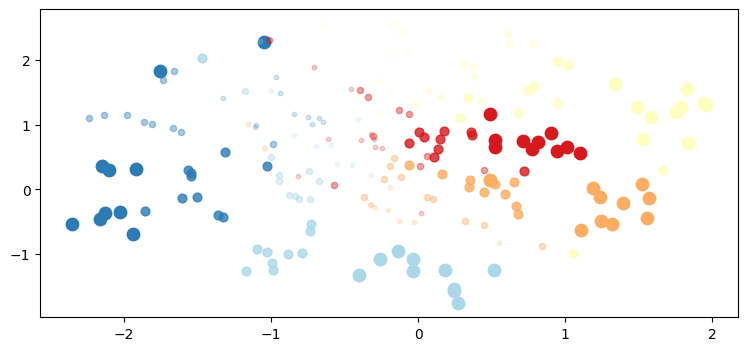

In [268]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

#main difference in this baseline is adding 20 BL/sham trials and using t_type_ind2 to keep track

trial_types  = ["64 kHz", "32 kHz", "16 kHz", "8 kHz", "4 kHz", "Baseline"]

#Xr = np.vstack([t[:, frames_pre_stim:frames_pre_stim+20].max(axis=1) for t in trials]).T
Xr = np.vstack([t[:, frames_pre_stim:frames_post_stim].mean(axis=1) for t in trials]).T
print(Xr.shape)

#we get the baseline trials here (20 in total, append to Xr)
k = 0
for j in range(20) :
    n = trials[j*10][:, 0:10]
    Xr = np.insert(Xr, 200 + k, n.mean(axis=1), axis = 1)
    k = k + 1
print(Xr.shape)
Xr_sc = z_score(Xr)

X_embedded = TSNE(n_components=2, perplexity=25, early_exaggeration=2, learning_rate=15, init="random").fit_transform(Xr_sc.T)
#these params need tweaking

fig = plt.figure(figsize=[9, 4])
for t, ind in enumerate(t_type_ind2):
    if t == 5 : #baseline
        for a, indexes in enumerate(ind):
            plt.scatter(X_embedded[indexes, 0], X_embedded[indexes, 1], c=pal[t], s=5, alpha=.2)
    else : #trial with attens
        for a, indexes in enumerate(ind):
            if a < 10 :
                plt.scatter(X_embedded[indexes, 0], X_embedded[indexes, 1], c=pal[t], s=80, alpha=1.0)
            elif a < 20 :
                plt.scatter(X_embedded[indexes, 0], X_embedded[indexes, 1], c=pal[t], s=40, alpha=0.8)
            elif a < 30 :
                plt.scatter(X_embedded[indexes, 0], X_embedded[indexes, 1], c=pal[t], s=20, alpha=0.4)
            else :
                plt.scatter(X_embedded[indexes, 0], X_embedded[indexes, 1], c=pal[t], s=10, alpha=0.2)

plt.title("t-SNE Projected Data")
plt.xlabel("Latent Component 1")
plt.ylabel("Latent Component 2")
add_orientation_legend(fig.get_axes()[0])

#X3_embedded = TSNE(n_components=3, perplexity=20, early_exaggeration=4, learning_rate=24, init="random").fit_transform(Xr_sc.T)
#fig = plt.figure(figsize=[9, 6])
#ax = fig.add_subplot(111, projection='3d')
#for t, ind in enumerate(t_type_ind):
    #ax.scatter(X3_embedded[ind, 0], X3_embedded[ind, 1], X3_embedded[ind, 2], c=pal[t], s=25, alpha=0.8)
#add_orientation_legend(ax)

#Xr = np.vstack([t[:, frames_pre_stim:frames_pre_stim+20].max(axis=1) for t in trials]).T
        #Xr = np.vstack([t[:, frames_pre_stim:-frames_post_stim].max(axis=1) for t in trials]).T
        # or the baseline-corrected mean
        #Xr = np.vstack([t[:, frames_pre_stim:-frames_post_stim].mean(axis=1) - t[:, 0:frames_pre_stim].mean(axis=1) for t in trials]).T

#Xr_sc = z_score(Xr)

fig = plt.figure(figsize=[12, 3])
plt.subplot(1, 2, 1)
for t, ind in enumerate(t_type_ind2):
    if t == 5 : #baseline
        for a, indexes in enumerate(ind):
            plt.scatter(X_embedded[indexes, 0], X_embedded[indexes, 1], c=pal[t], s=5, alpha=.2)
    else : #trial with attens
        for a, indexes in enumerate(ind):
            if a < 10 : 
                plt.scatter(X_embedded[indexes, 0], X_embedded[indexes, 1], c=pal[t], s=80, alpha=1.0)
            elif a < 20 :
                plt.scatter(X_embedded[indexes, 0], X_embedded[indexes, 1], c=pal[t], s=40, alpha=0.8)
            elif a < 30 :
                plt.scatter(X_embedded[indexes, 0], X_embedded[indexes, 1], c=pal[t], s=20, alpha=0.4)
            else :
                plt.scatter(X_embedded[indexes, 0], X_embedded[indexes, 1], c=pal[t], s=10, alpha=0.2)

plt.title("t-SNE Projected Data")
plt.xlabel("Latent Component 1")
plt.ylabel("Latent Component 2")
add_orientation_legend(fig.get_axes()[0])
pca = PCA(n_components=15)
Xp = pca.fit_transform(Xr_sc.T).T
projections = [(0, 1)] #projections = [(2, 0), (2, 1), (2, 3), (2, 4), (2,5)]
counter = 0
xhats = np.zeros((1, 220, 2)) #change if no baseline

plt.subplot(1, 2, 2)
for proj in projections:
    print("PCs:", proj)
    for t, t_type in enumerate(trial_types):
        print("t_type:", t_type)
        x = Xp[proj[0], t_type_ind2[t]]
        y = Xp[proj[1], t_type_ind2[t]]
                
        xhats[counter, t_type_ind2[t], 0] = x
        xhats[counter, t_type_ind2[t], 1] = y

        plt.scatter(x, y, c=pal[t], s=25, alpha=0.8)
        plt.xlabel('PC {}'.format(proj[0]+1))
        plt.ylabel('PC {}'.format(proj[1]+1))

plt.title("PCA Projected Data")
add_orientation_legend(fig.get_axes()[0])

Kmeans: Tone Classification

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 4 4 4 4 0 0
 4 4 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 4 4 4 4
 4 4 4 4 4 4 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 3
 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]
(200,)
(200,)
0.905


Text(0.5, 1.0, 'Classification Accuracy:0.905')

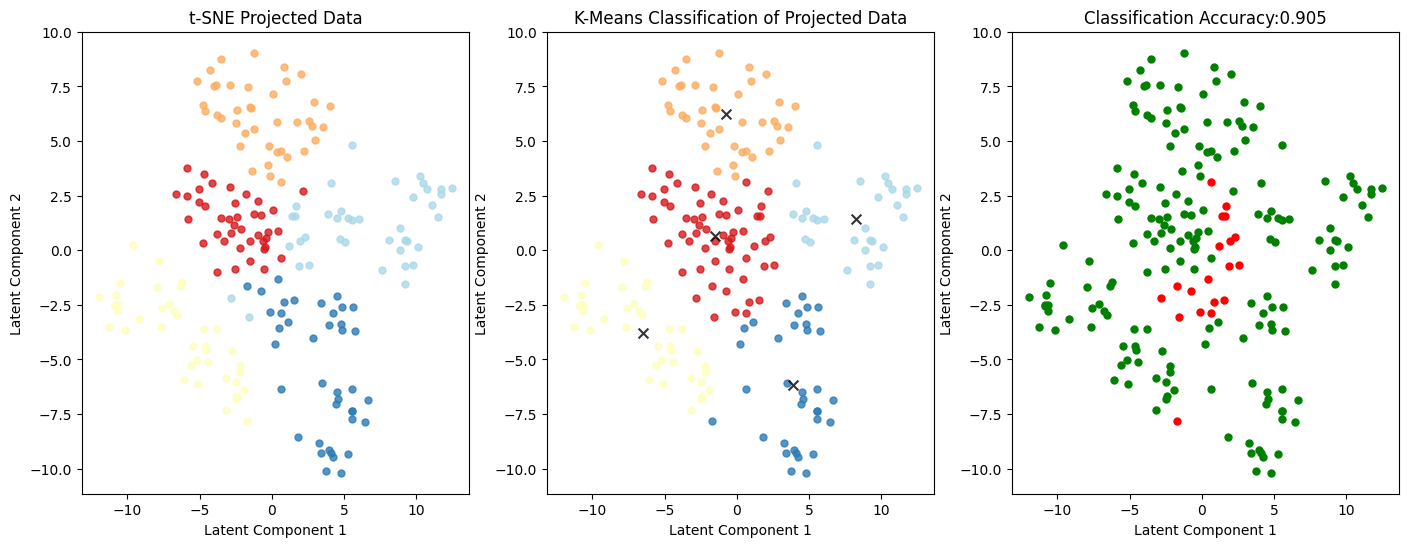

In [265]:
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score

#no bl
centers_init = np.zeros([5, 2])
for t, ind in enumerate(t_type_ind):
    centers_init[t, :] = np.mean(X_embedded[ind, :], axis = 0)
kmeans = KMeans(n_clusters=5, random_state=0, init = centers_init).fit(X_embedded)

#for baseline included
#centers_init = np.zeros([6, 2])
#for t, ind in enumerate(t_type_ind2):
    #centers_init[t, :] = np.mean(X_embedded[ind, :], axis = 0)
#kmeans = KMeans(n_clusters=6, random_state=0, init = centers_init).fit(X_embedded)


#kmeans = KMeans(n_clusters=21, random_state=0).fit(X_embedded)


fig = plt.figure(figsize=[17, 6])
for t, ind in enumerate(t_type_ind):
    plt.subplot(1, 3, 1)
    plt.scatter(X_embedded[ind, 0], X_embedded[ind, 1], c=pal[t], s=25, alpha=0.8)
    plt.subplot(1, 3, 2)
    for indeces in ind :
        plt.scatter(X_embedded[indeces, 0], X_embedded[indeces, 1], c=pal[kmeans.labels_[indeces]], s=25, alpha=0.8)
        #plt.scatter(X_embedded[indeces, 0], X_embedded[indeces, 1], s=25, alpha=0.8)
print(kmeans.labels_)

plt.subplot(1, 3, 1)
plt.title("t-SNE Projected Data")
plt.xlabel("Latent Component 1")
plt.ylabel("Latent Component 2")

plt.subplot(1, 3, 2)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='black', marker='x', s=50, alpha=0.8)
plt.title("K-Means Classification of Projected Data")
plt.xlabel("Latent Component 1")
plt.ylabel("Latent Component 2")

#for tone classif
acc_labels = np.zeros(len(kmeans.labels_))
for t, ind in enumerate(t_type_ind):
    for indeces in ind :
        if kmeans.labels_[indeces] == t :
            acc_labels[indeces] = 1

y = np.ones(len(acc_labels))

print(y.shape)
print(acc_labels.shape)
cdict = {0.0: 'red', 1.0: 'green'}
plt.subplot(1, 3, 3)
plt.xlabel("Latent Component 1")
plt.ylabel("Latent Component 2")
for t, ind in enumerate(t_type_ind):
    for indeces in ind :
        plt.scatter(X_embedded[indeces, 0], X_embedded[indeces, 1], c = cdict[acc_labels[indeces]], s = 25)

print(accuracy_score(y, acc_labels))
plt.title("Classification Accuracy:" + str(accuracy_score(y, acc_labels)))

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.
 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 4. 4. 4. 4. 4. 4. 4. 4.
 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4.
 4. 4. 4. 4. 4. 4. 4. 4.]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 4 4 4 4 0 0
 4 4 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 4 4 4 4
 4 4 4 4 4 4 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 3
 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 

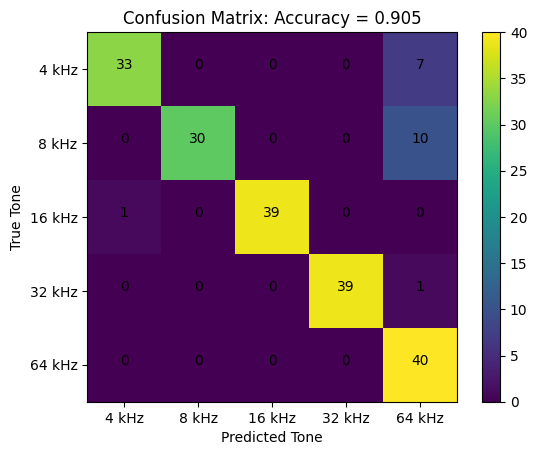

In [235]:
import itertools
from sklearn.metrics import confusion_matrix

ytrue = np.zeros((200))
for t, ind in enumerate(t_type_ind):
    ytrue[ind] = t

print(ytrue)
print(kmeans.labels_)

cm = confusion_matrix(ytrue, kmeans.labels_)
plt.figure()
plt.xlabel("Predicted Tone")
plt.ylabel("True Tone")
plt.imshow(cm)
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment="center")
plt.colorbar()
plt.yticks([0, 1, 2, 3, 4], ["4 kHz", "8 kHz", "16 kHz", "32 kHz", "64 kHz"])
plt.xticks([0, 1, 2, 3, 4], ["4 kHz", "8 kHz", "16 kHz", "32 kHz", "64 kHz"])
#pval = stats.binom_test(testTrials * accuracy_score(y_test, y_pred), n=testTrials, p=.2, alternative='greater')
print('Accuracy:', str(accuracy_score(ytrue, kmeans.labels_)))
#print("P-Value:", pval)
plt.title("Confusion Matrix: Accuracy = " + str(accuracy_score(ytrue, kmeans.labels_)))
nam = "confusion_matrix" 
#plt.savefig(Path(self.output_dir, nam))


(200, 2)


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

[ 0  0  0  0 11  0  0  0  0  0  1  1  1  1  1  1  1  1  1  1  2  2  2  2
  2  2  2  2  2  2  3  3  3  3  3  3  3  3  3  3  4  4  4  4  4  4  4  4
  4  4  5  5  5  5  5  5  5  5  5  5  6  6  6  6  6  6  6  6  6  6  3  7
  7  7  7  7  7  3  7  7  8  8  8  8  8  8  8  8  8  8  9  9  9  9  9  9
  9  9  8  9 10 10 10 10 10 10 10 10 10 10 11 11 11 11 11 11 11 11 11 11
 12 12 12 12 12 12 12 12 12 12 14 13 13 13 13 13 13 13 13 13 14 14 14 14
 14 14 14 15 13 15 15 15 15 14 15 15 15 15 15 15 16 16 16 16 16 17 16 16
 16 16 17 18 17 17 17 17 17 17 17 17 18 17 18 18 19 18 18 18 18 18 19 19
 19 19 19 18 19 19 19  7]


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

[ 0  0  0  0 11  0  0  0  0  0  1  1  1  1  1  1  1  1  1  1  2  2  2  2
  2  2  2  2  2  2  3  3  3  3  3  3  3  3  3  3  4  4  4  4  4  4  4  4
  4  4  5  5  5  5  5  5  5  5  5  5  6  6  6  6  6  6  6  6  6  6  3  7
  7  7  7  7  7  3  7  7  8  8  8  8  8  8  8  8  8  8  9  9  9  9  9  9
  9  9  8  9 10 10 10 10 10 10 10 10 10 10 11 11 11 11 11 11 11 11 11 11
 12 12 12 12 12 12 12 12 12 12 14 13 13 13 13 13 13 13 13 13 14 14 14 14
 14 14 14 15 13 15 15 15 15 14 15 15 15 15 15 15 16 16 16 16 16 17 16 16
 16 16 17 18 17 17 17 17 17 17 17 17 18 17 18 18 19 18 18 18 18 18 19 19
 19 19 19 18 19 19 19  7]
(200,)
(200,)
0.925


Text(0.5, 1.0, 'Classification Accuracy:0.925')

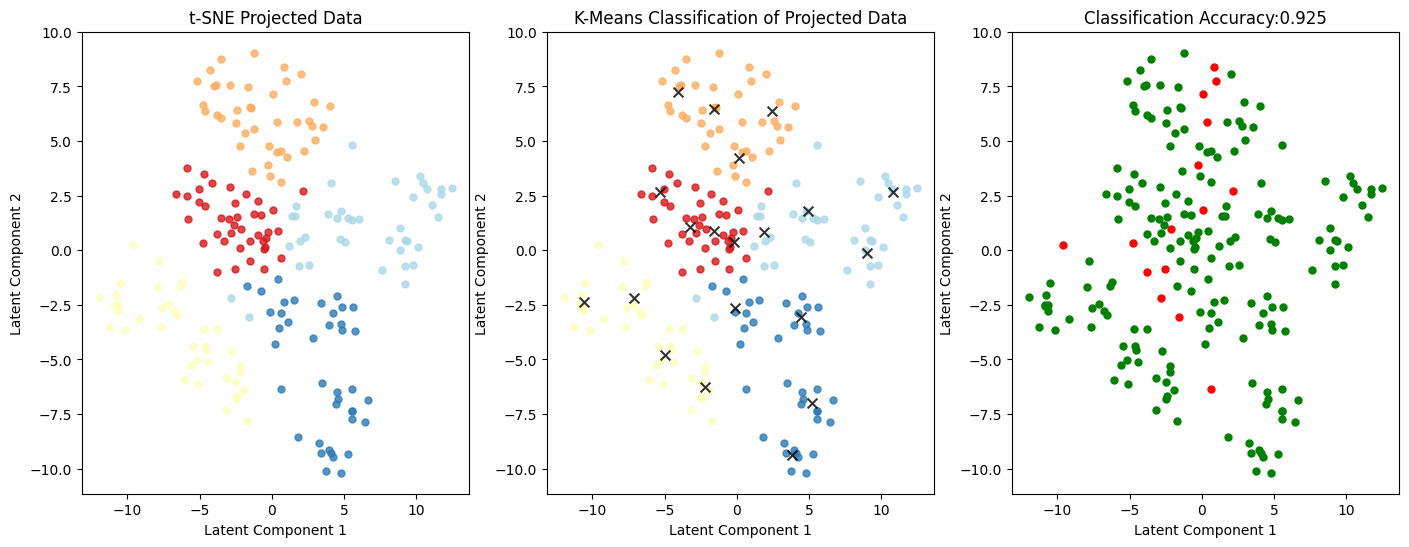

In [267]:
centers_init = np.zeros([20, 2])
print(X_embedded.shape)
for i in range(centers_init.shape[0]) :
    centers_init[i, :] = X_embedded[10*i:10*i + 10, :].mean(axis=0)
kmeans = KMeans(n_clusters=20, random_state=0, init=centers_init).fit(X_embedded)
print(kmeans.labels_)

fig = plt.figure(figsize=[17, 6])
for t, ind in enumerate(t_type_ind):
    plt.subplot(1, 3, 1)
    plt.scatter(X_embedded[ind, 0], X_embedded[ind, 1], c=pal[t], s=25, alpha=0.8)
    plt.subplot(1, 3, 2)
    for indeces in ind :
        plt.scatter(X_embedded[indeces, 0], X_embedded[indeces, 1], c=pal[t], s=25, alpha=0.8)
        #plt.scatter(X_embedded[indeces, 0], X_embedded[indeces, 1], s=25, alpha=0.8)
print(kmeans.labels_)

plt.subplot(1, 3, 1)
plt.title("t-SNE Projected Data")
plt.xlabel("Latent Component 1")
plt.ylabel("Latent Component 2")

plt.subplot(1, 3, 2)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='black', marker='x', s=50, alpha=0.8)
plt.title("Projected Data with Cluster Centers")
plt.xlabel("Latent Component 1")
plt.ylabel("Latent Component 2")

#for tone classif
ytrue = np.zeros((200))
counter = 0
indCount = 0
for t, ind in enumerate(t_type_ind):
    for k in range(4) :
        for rep in range(10) :
            ytrue[indCount] = counter
            indCount = indCount + 1
        counter = counter + 1

acc_labels = np.zeros(len(kmeans.labels_))
for t, ind in enumerate(t_type_ind):
    for indeces in ind :
        if kmeans.labels_[indeces] == ytrue[indeces] :
            acc_labels[indeces] = 1

y = np.ones(len(acc_labels))

print(y.shape)
print(acc_labels.shape)
cdict = {0.0: 'red', 1.0: 'green'}
plt.subplot(1, 3, 3)
plt.xlabel("Latent Component 1")
plt.ylabel("Latent Component 2")
for t, ind in enumerate(t_type_ind):
    for indeces in ind :
        plt.scatter(X_embedded[indeces, 0], X_embedded[indeces, 1], c = cdict[acc_labels[indeces]], s = 25)

print(accuracy_score(y, acc_labels))
plt.title("Classification Accuracy:" + str(accuracy_score(y, acc_labels)))

20
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  3.  3.  3.  3.  3.  3.
  3.  3.  3.  3.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  5.  5.  5.  5.
  5.  5.  5.  5.  5.  5.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  7.  7.
  7.  7.  7.  7.  7.  7.  7.  7.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.
  9.  9.  9.  9.  9.  9.  9.  9.  9.  9. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 11. 11. 11. 11. 11. 11. 11. 11. 11. 11. 12. 12. 12. 12. 12. 12.
 12. 12. 12. 12. 13. 13. 13. 13. 13. 13. 13. 13. 13. 13. 14. 14. 14. 14.
 14. 14. 14. 14. 14. 14. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 16. 16.
 16. 16. 16. 16. 16. 16. 16. 16. 17. 17. 17. 17. 17. 17. 17. 17. 17. 17.
 18. 18. 18. 18. 18. 18. 18. 18. 18. 18. 19. 19. 19. 19. 19. 19. 19. 19.
 19. 19.]
[ 0  0  0  0 11  0  0  0  0  0  1  1  1  1  1  1  1  1  1  1  2  2  2  2
  2  2  2  2  2  2  3  3  3  3  3  3  3  3  3  3  4  4  4  4  4  4  4  4
  4  4  5  5  5  5  5  5  5  5  5  5  

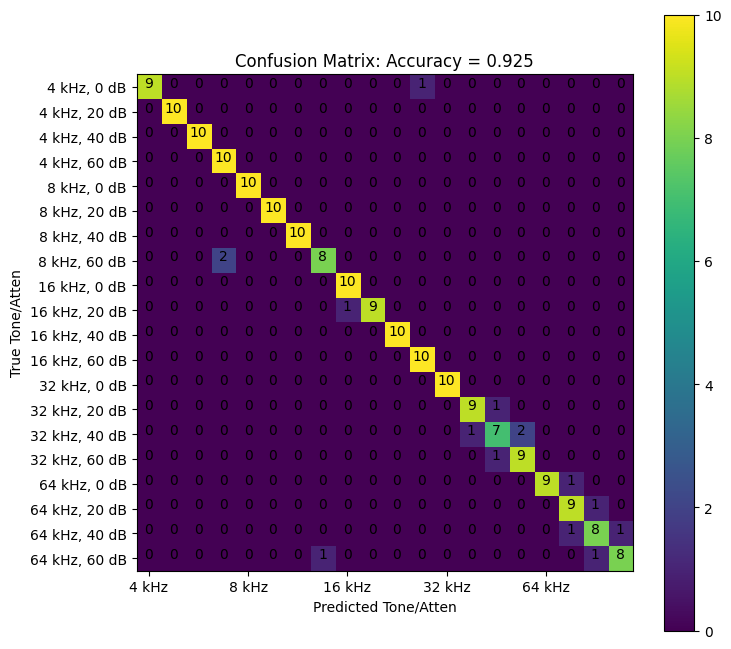

In [261]:
import itertools
from sklearn.metrics import confusion_matrix

ytrue = np.zeros((200))
counter = 0
indCount = 0
for t, ind in enumerate(t_type_ind):
    for k in range(4) :
        for rep in range(10) :
            ytrue[indCount] = counter
            indCount = indCount + 1
        counter = counter + 1

print(counter)

print(ytrue)
print(kmeans.labels_)

cm = confusion_matrix(ytrue, kmeans.labels_)
plt.figure(figsize = [8,8])
plt.xlabel("Predicted Tone/Atten")
plt.ylabel("True Tone/Atten")
plt.imshow(cm)
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment="center")
plt.colorbar()
plt.yticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19], ["4 kHz, 0 dB", "4 kHz, 20 dB", "4 kHz, 40 dB", "4 kHz, 60 dB", 
                         "8 kHz, 0 dB", "8 kHz, 20 dB", "8 kHz, 40 dB", "8 kHz, 60 dB",
                         "16 kHz, 0 dB", "16 kHz, 20 dB", "16 kHz, 40 dB", "16 kHz, 60 dB",
                         "32 kHz, 0 dB", "32 kHz, 20 dB", "32 kHz, 40 dB", "32 kHz, 60 dB",
                         "64 kHz, 0 dB", "64 kHz, 20 dB", "64 kHz, 40 dB", "64 kHz, 60 dB"])
plt.xticks([0,4,8,12,16], ["4 kHz", "8 kHz", "16 kHz", "32 kHz", "64 kHz"])
#pval = stats.binom_test(testTrials * accuracy_score(y_test, y_pred), n=testTrials, p=.2, alternative='greater')
print('Accuracy:', str(accuracy_score(ytrue, kmeans.labels_)))
#print("P-Value:", pval)
plt.title("Confusion Matrix: Accuracy = " + str(accuracy_score(ytrue, kmeans.labels_)))
nam = "confusion_matrix" 
#plt.savefig(Path(self.output_dir, nam))
